1. IMPORTING LIBRARIES

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Setting the style
sns.set(style='whitegrid')

2. LOADING THE DATA

In [46]:
trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')

3. DATA CLEANING AND PREPARATION

In [47]:
# Data Cleaning and preparation of the sentiment data

# Cleaning whitespace and unexpected characters
sentiment_df['date'] = sentiment_df['date'].astype(str).str.strip()

# Trying to parse the date column robustly
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce', dayfirst=True)

# Dropping invalid date rows
sentiment_df = sentiment_df.dropna(subset=['date'])

# Renaming the columns for clarity
sentiment_df = sentiment_df.rename(columns={'classification': 'sentiment'})

In [48]:
# Data Cleaning and preparation of the trader data

# Converting trader data timestamp to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], dayfirst=True, errors='coerce')

# Normalizing to date only (no time) for merging
trader_df['date'] = trader_df['Timestamp IST'].dt.normalize()

# Converting numeric columns to appropriate types
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')

4. MERGING THE SENTIMENT DATA WITH TRADER DATA ON DATE

In [49]:
# Merging on date (left join so we keep only trades with sentiment info)
merged_df = pd.merge(trader_df, sentiment_df[['date', 'sentiment']], on='date', how='left')


In [50]:
# Dropping rows where sentiment is missing (trades on dates without sentiment data)
merged_df = merged_df.dropna(subset=['sentiment'])

In [51]:
# Previewing the merged data
print(merged_df[['date', 'Size USD', 'Closed PnL', 'sentiment']].head())

        date  Size USD  Closed PnL sentiment
0 2024-12-02   7872.16         0.0     Greed
1 2024-12-02    127.68         0.0     Greed
2 2024-12-02   1150.63         0.0     Greed
3 2024-12-02   1142.04         0.0     Greed
4 2024-12-02     69.75         0.0     Greed


5. MAPPING SENTIMENT LEVELS TO NUMERICAL SCORES

In [52]:
sentiment_scores = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}

merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_scores)

6. EXPLORATORY DATA ANALYSIS AND VISUALIZATION

<ipython-input-53-619e90973501>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Closed PnL', data=merged_df, palette='coolwarm')


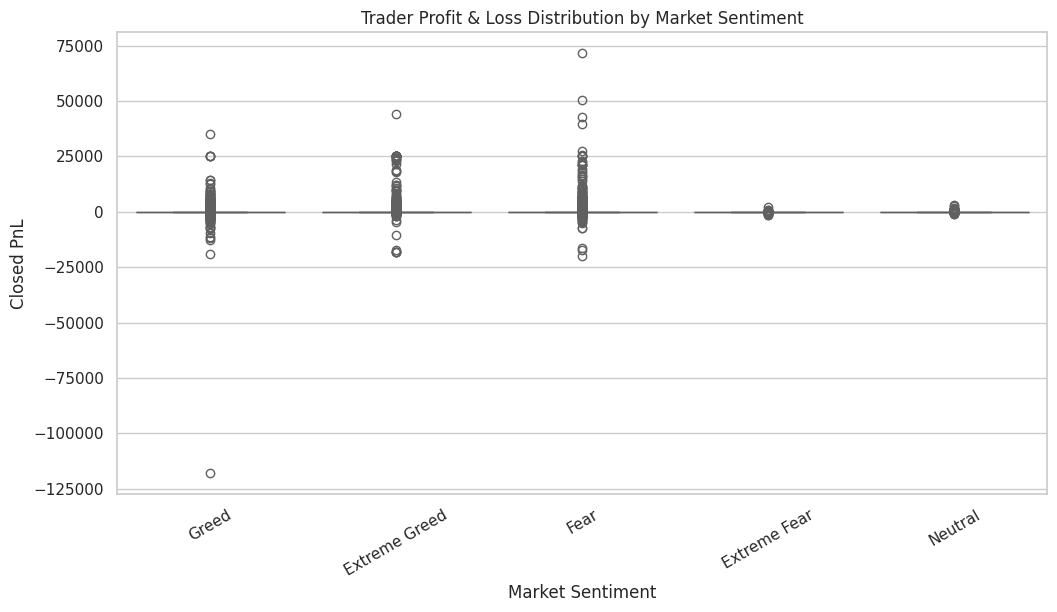

In [53]:
# a. Distribution of Closed PnL by Sentiment
# Insight: Visualizing if traders tend to be more profitable during Greed or Fear phases.
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='Closed PnL', data=merged_df, palette='coolwarm')
plt.title('Trader Profit & Loss Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.xticks(rotation=30)
plt.show()

In [54]:
# b. Average PnL and Trade Size by Sentiment
# Insight: Are bigger trades or better profits correlated with certain sentiment?
summary_stats = merged_df.groupby('sentiment').agg({
    'Closed PnL': ['mean', 'median'],
    'Size USD': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

summary_stats.columns = ['Sentiment', 'Avg Closed PnL', 'Median Closed PnL', 'Avg Trade Size USD', 'Avg Sentiment Score']

print(summary_stats)

       Sentiment  Avg Closed PnL  Median Closed PnL  Avg Trade Size USD  \
0   Extreme Fear        1.891632            0.00000         4118.761840   
1  Extreme Greed      205.816345            0.96048         3242.085086   
2           Fear      128.287950            0.00000         5744.782685   
3          Greed       53.988003            0.00000         5051.878829   
4        Neutral       27.088803            0.00000         4332.202906   

   Avg Sentiment Score  
0                  1.0  
1                  5.0  
2                  2.0  
3                  4.0  
4                  3.0  


<ipython-input-55-725ff70fe013>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Win Rate', data=win_rate, palette='viridis')


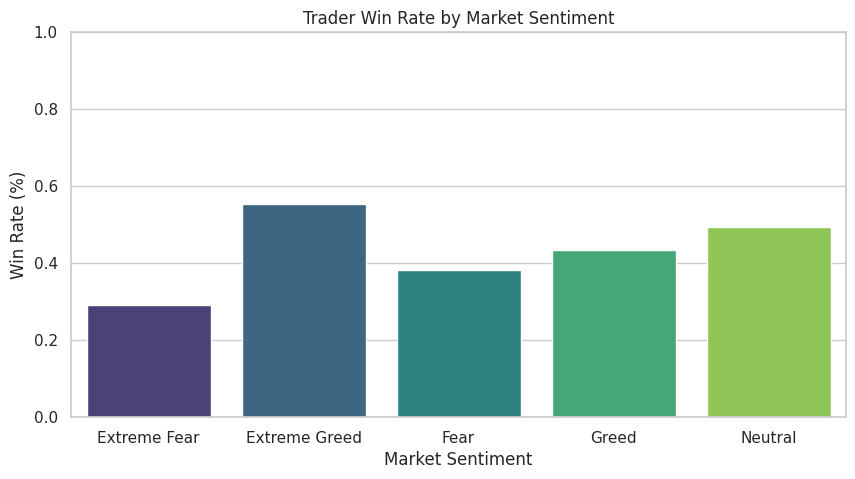

In [55]:
# c. Trader Win Rate by Sentiment
# Insight: Identifying if traders tend to win more often during Fear or Greed.
merged_df['win'] = merged_df['Closed PnL'] > 0

win_rate = merged_df.groupby('sentiment')['win'].mean().reset_index()
win_rate.columns = ['Sentiment', 'Win Rate']

plt.figure(figsize=(10,5))
sns.barplot(x='Sentiment', y='Win Rate', data=win_rate, palette='viridis')
plt.title('Trader Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment')
plt.ylim(0, 1)
plt.show()


In [56]:
# d. Correlation between sentiment score and PnL
corr = np.corrcoef(merged_df['sentiment_score'].dropna(), merged_df['Closed PnL'].dropna())[0,1]
print(f"Correlation between Sentiment Score and Closed PnL: {corr:.4f}")

Correlation between Sentiment Score and Closed PnL: 0.0119


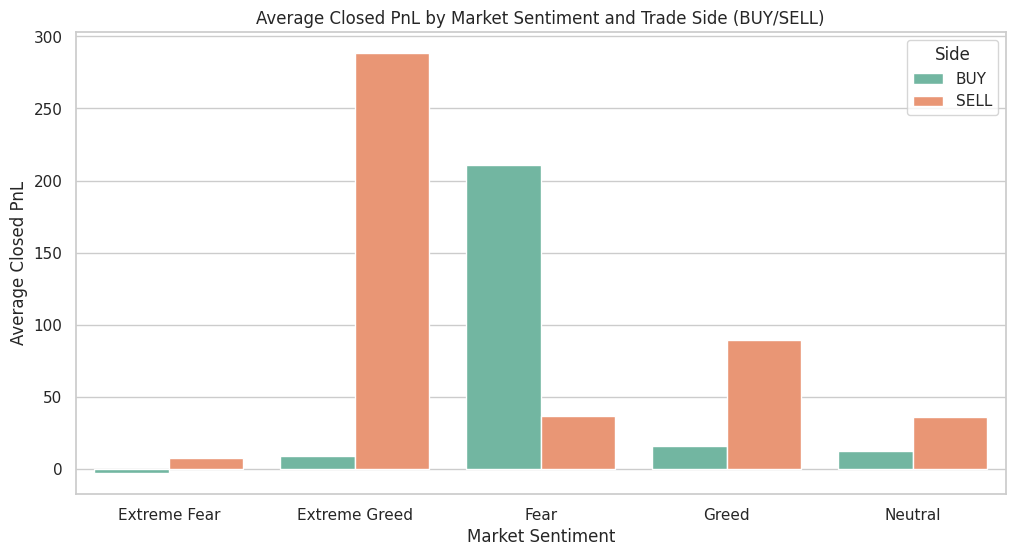

In [57]:
# e. Advanced insight: Performance by side (BUY/SELL) across sentiment
# Insight: Does buying vs selling perform differently in Fear vs Greed?
side_sentiment = merged_df.groupby(['sentiment', 'Side']).agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean'
}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='sentiment', y='Closed PnL', hue='Side', data=side_sentiment, palette='Set2')
plt.title('Average Closed PnL by Market Sentiment and Trade Side (BUY/SELL)')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.show()

### Final Project Summary – Trader Behavior vs. Market Sentiment

1. **Higher Profits During Fear:**  
   Traders earn more on average during *Fear* phases, indicating volatility-driven opportunities in declining markets.

2. **Extreme Greed Has Highest Win Rate:**  
   Win rates peak during *Extreme Greed*, suggesting stable, trend-following conditions support consistent trading success.

3. **Trade Size Strategy Differs by Sentiment:**  
   Largest trades occur during *Fear*, reflecting opportunistic buying when prices are lower and volatility is high.

4. **Buy vs. Sell Performance:**  
   - *Buy trades* yield the most during *Fear* – ideal for value entries.  
   - *Sell trades* peak in *Extreme Greed* – perfect for profit-taking or shorting.

5. **Low Correlation with Sentiment Score:**  
   Weak correlation (0.0119) shows that sentiment alone doesn’t dictate profit – execution strategy and timing matter more.




###  Strategic Implication:

Smart traders can gain an edge by **aligning strategy with sentiment**: enter buys in fearful markets and consider selling during greed phases, while applying risk controls regardless of sentiment levels.